In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib.tri import Triangulation

import ast

In [4]:
def parse_results(file_name):
    grid_search_results = []
    with open(file_name, 'r') as file:
        for line in file.readlines():
            if line[0:4] == '----':
                grid_search_results.append([])
                continue

            if line[0] == '(':
                fixed_line = '[' + line.strip().replace(') (', '), (') + ']'
                params = ast.literal_eval(fixed_line)
                nested = [list(zip(key.split(','), np.array(val).flatten())) for (key, val) in params]
                unnested = [item for sublist in nested for item in sublist]
                grid_search_results[-1].append({key: val for (key, val) in unnested})
                grid_search_results[-1].append([])
                continue

            result = line

            if result[0] == '[':
                grid_search_results[-1][-1].append(ast.literal_eval(result))
                continue

    grid_search_results = [(params, np.array(values)) for params, values in grid_search_results]
    return grid_search_results

In [121]:
both_res = parse_results('grid_search_results/euc_small_2000.txt')
# hyp_res = both_res[:len(both_res)//2]
# euc_res = both_res[len(both_res)//2:]
hyp_res = both_res
euc_res = both_res

In [122]:
hyp_params = np.array([p for p, _ in hyp_res])
hyp_values = np.array([v for _, v in hyp_res])

euc_params = np.array([p for p, _ in euc_res])
euc_values = np.array([v for _, v in euc_res])

hyp_values.shape, euc_values.shape

((30, 4, 2000), (30, 4, 2000))

In [123]:
NUM_HIDDEN_LAYERS = sorted(list(set([p['num_hidden_layers'] for p in hyp_params]).union(set([p['num_hidden_layers'] for p in euc_params]))))
LAYER_SIZE = sorted(list(set([p['layer_size'] for p in hyp_params]).union(set([p['layer_size'] for p in euc_params]))))
LR = sorted(list(set([p['lr'] for p in hyp_params]).union(set([p['lr'] for p in euc_params]))))
WD = sorted(list(set([p['weight_decay'] for p in hyp_params]).union(set([p['weight_decay'] for p in euc_params]))))

In [124]:
print(NUM_HIDDEN_LAYERS)
print(LAYER_SIZE)
print(LR)
print(WD)

[1]
[2, 4, 8, 16, 64]
[0.005, 0.01, 0.015]
[0.003, 0.005]


In [125]:
num_hidden_layers = np.array(NUM_HIDDEN_LAYERS).repeat(len(LAYER_SIZE))
layer_size = np.tile(LAYER_SIZE, len(NUM_HIDDEN_LAYERS))

In [126]:
hyp_values[0::len(WD)].mean(axis=1)[:,-1].reshape(-1,len(LR))[:,0].shape

(5,)

In [127]:
num_hidden_layers.shape, layer_size.shape

((5,), (5,))

In [128]:
for i, wd in enumerate(WD):
    print(f'--------------- Weight Decay: {wd} ---------------')
    hyp_values_wd = hyp_values[i::len(WD)]
    euc_values_wd = euc_values[i::len(WD)]
    for i, lr in enumerate(LR):
        hyp_data = hyp_values_wd.mean(axis=1)[:,-1].reshape(-1,len(LR))[:,i].clip(0,0.1)
        euc_data = euc_values_wd.mean(axis=1)[:,-1].reshape(-1,len(LR))[:,i].clip(0,0.1)

        min_val = min(np.min(hyp_data), np.min(euc_data))
        max_val = max(np.max(hyp_data), np.max(euc_data))

        cmap = plt.cm.viridis
        norm = Normalize(vmin=min_val, vmax=max_val)


        num_hidden_layers_adjust = num_hidden_layers.astype(float)
        num_hidden_layers_adjust[num_hidden_layers_adjust == 0] = 0.5

        mesh = Triangulation(num_hidden_layers_adjust, layer_size)  #create tri mesh


        plt.figure(figsize=(15,8))
        plt.suptitle(f'Hyperbolic     |lr = {lr}|     Euclidean', fontsize=16, y=1)

        plt.subplot(121)
        plt.tricontourf(mesh, hyp_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
        plt.scatter(num_hidden_layers_adjust, layer_size, c=hyp_data, cmap=cmap, norm=norm)

        plt.title(f'Hyperbolic MAE={np.min(hyp_data):.3}')
        plt.xlabel('Num Hidden Layers')
        plt.ylabel('Layer Size')

        plt.xscale('log', base=2)
        plt.yscale('log', base=2)


        plt.subplot(122)
        euc_contourf = plt.tricontourf(mesh, euc_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
        euc_scatter = plt.scatter(num_hidden_layers_adjust, layer_size, c=euc_data, cmap=cmap, norm=norm)
        plt.colorbar(euc_scatter, label='MAE')


        plt.title(f'Euclidean R2={np.min(euc_data):.3}')
        plt.xlabel('Num Hidden Layers')
        plt.ylabel('Layer Size')

        plt.xscale('log', base=2)
        plt.yscale('log', base=2)

        plt.tight_layout()
        plt.show()

--------------- Weight Decay: 0.003 ---------------


RuntimeError: Error in qhull Delaunay triangulation calculation: input inconsistency (exitcode=1); use python verbose option (-v) to see original qhull error.

<h3>ALL</h3>

- Hyp: 0.029
- Euc: 0.029


In [139]:
K = 299

best_hyp_params = np.argsort(hyp_values.mean(axis=1)[:,K])[:30]
print(hyp_values.mean(axis=1)[:,K][best_hyp_params])
print()
best_euc_params = np.argsort(euc_values.mean(axis=1)[:,K])[:30]
print(euc_values.mean(axis=1)[:,K][best_euc_params])

best_hyp_runs = hyp_values.mean(axis=1)[best_hyp_params]
best_euc_runs = euc_values.mean(axis=1)[best_euc_params]

[0.02923972 0.02943547 0.02953033 0.02957609 0.02961335 0.02974935
 0.0297845  0.02983135 0.02984859 0.02986908 0.02987156 0.0299419
 0.0300832  0.0300927  0.03009534 0.03027551 0.03037106 0.03072491
 0.03074212 0.03113102 0.03134947 0.03150944 0.03176228 0.03184963
 0.03227565 0.03248054 0.03270833 0.03392753 0.03765511 0.03767607]

[0.02923972 0.02943547 0.02953033 0.02957609 0.02961335 0.02974935
 0.0297845  0.02983135 0.02984859 0.02986908 0.02987156 0.0299419
 0.0300832  0.0300927  0.03009534 0.03027551 0.03037106 0.03072491
 0.03074212 0.03113102 0.03134947 0.03150944 0.03176228 0.03184963
 0.03227565 0.03248054 0.03270833 0.03392753 0.03765511 0.03767607]


In [140]:
# print(hyp_params[best_hyp_params])
# print()
print(euc_params[best_euc_params])

[{'model_type': 'euc', 'num_hidden_layers': 1, 'layer_size': 64, 'lr': 0.01, 'weight_decay': 0.003, 'batch_size': 1024, 'epochs': 2000, 'curvature': -1}
 {'model_type': 'euc', 'num_hidden_layers': 1, 'layer_size': 2, 'lr': 0.015, 'weight_decay': 0.003, 'batch_size': 1024, 'epochs': 2000, 'curvature': -1}
 {'model_type': 'euc', 'num_hidden_layers': 1, 'layer_size': 64, 'lr': 0.005, 'weight_decay': 0.005, 'batch_size': 1024, 'epochs': 2000, 'curvature': -1}
 {'model_type': 'euc', 'num_hidden_layers': 1, 'layer_size': 64, 'lr': 0.01, 'weight_decay': 0.005, 'batch_size': 1024, 'epochs': 2000, 'curvature': -1}
 {'model_type': 'euc', 'num_hidden_layers': 1, 'layer_size': 16, 'lr': 0.01, 'weight_decay': 0.005, 'batch_size': 1024, 'epochs': 2000, 'curvature': -1}
 {'model_type': 'euc', 'num_hidden_layers': 1, 'layer_size': 64, 'lr': 0.015, 'weight_decay': 0.005, 'batch_size': 1024, 'epochs': 2000, 'curvature': -1}
 {'model_type': 'euc', 'num_hidden_layers': 1, 'layer_size': 64, 'lr': 0.015, 'w

In [91]:
print(np.mean((best_hyp_runs[:,-50] - best_hyp_runs[:,-1])/best_hyp_runs[:,-50]))
print(np.mean((best_euc_runs[:,-50] - best_euc_runs[:,-1])/best_euc_runs[:,-50]))

0.004976775853150436
0.004976775853150436


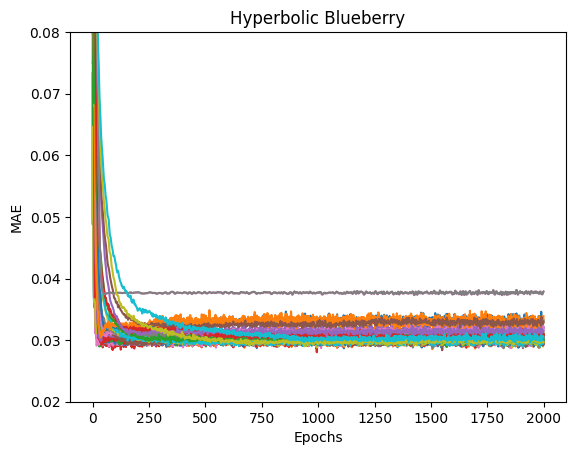

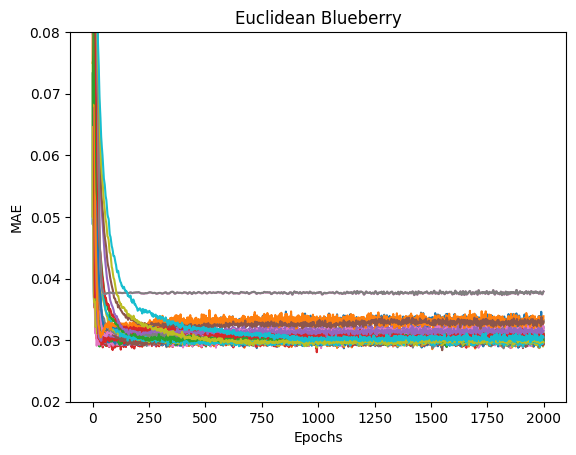

In [92]:
for run in hyp_values.mean(axis=1)[best_hyp_params]:
    plt.plot(run)
    # plt.plot(run[25:])

plt.title('Hyperbolic Blueberry')
plt.ylabel('MAE')
plt.xlabel('Epochs')

plt.ylim(0.02,0.08)
# plt.yscale('log')
plt.show()

for run in euc_values.mean(axis=1)[best_euc_params]:
    plt.plot(run)
    # plt.plot(run[25:])

plt.title('Euclidean Blueberry')
plt.ylabel('MAE')
plt.xlabel('Epochs')

plt.ylim(0.02,0.08)
# plt.yscale('log')
plt.show()
